# PUBG
Battle Royale-style video games have taken the world by storm. 100 players are dropped onto an island empty-handed and must explore, scavenge, and eliminate other players until only one is left standing, all while the play zone continues to shrink.

PlayerUnknown's BattleGrounds (PUBG) has enjoyed massive popularity. With over 50 million copies sold, it's the fifth best selling game of all time, and has millions of active monthly players.

The team at PUBG has made official game data available for the public to explore and scavenge outside of "The Blue Circle." This competition is not an official or affiliated PUBG site - Kaggle collected data made possible through the PUBG Developer API.

You are given over 65,000 games' worth of anonymized player data, split into training and testing sets, and asked to predict final placement from final in-game stats and initial player ratings.

What's the best strategy to win in PUBG? Should you sit in one spot and hide your way into victory, or do you need to be the top shot? Let's let the data do the talking!

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
train = pd.read_csv('../input/train_V2.csv')
test = pd.read_csv('../input/test_V2.csv')

In [ ]:
train.head()

In [ ]:
train.shape, test.shape

In [ ]:
# train = train[:500000]

In [ ]:
test.head()

In [ ]:
train.columns

In [ ]:
target_col = 'winPlacePerc'

In [ ]:
train.drop(2744604, inplace=True, errors='ignore')

# Decision Trees
Lets build a decision tree regrassor,
Regrasor is a meachine learning model which is used to predict continous variable.
Since We expect to have a continous functional relationship between input and final output. It's better to use Regrassor for this problem.

# Prepare data


In [ ]:
train.dtypes

So Most of our variables are int or float64. Thats good :)
Let's explore some variables that are strings.

In [ ]:
train['Id'].describe()

So Id is unique as we expected. 

In [ ]:
train['groupId'].describe()

In [ ]:
train['matchId'].describe()

So groupId looks like a identifier for a team and match ID is a identifier for a match. Remember in pubG a team can have 4 people and match can have 100 people.
obviously who is on your team and who are other players in your match is going to matter a lot but let's build some basic model without these 2 features.
It's always good idea to build something working and simple first to understand the complexity of the problem we are dealing with and get some base score.

matchType is another string field. We have to convert that to numerical variable. 

In [ ]:
train['matchType'].describe()

In [ ]:
train['matchType'].unique()

There are basically 2 ways to convert string column to  numerical. 
* Assign a unique number to each of the category.
* use one hot encoding 
We have 16 unique value so it's a good candidate for one hot encoding.

In [ ]:
pd.get_dummies(train['matchType']).head() # getting one hot encoded dataframe

In [ ]:
# Get one hot encoding of columns matchType
one_hot_train = pd.get_dummies(train['matchType'])
# Drop column B as it is now encoded
train = train.drop('matchType', axis = 1)
# Join the encoded df
train = train.join(one_hot_train)
train.head()

In [ ]:
# Get one hot encoding of columns matchType
one_hot_test = pd.get_dummies(test['matchType'])
# Drop column B as it is now encoded
test = test.drop('matchType', axis = 1)
# Join the encoded df
test = test.join(one_hot_test)
test.head()

# Feature Engineering

In [ ]:
print("Adding Features")
def add_feature(df):
    df['headshotrate'] = df['kills']/df['headshotKills']
    df['killStreakrate'] = df['killStreaks']/df['kills']
    df['healthitems'] = df['heals'] + df['boosts']
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['distance_over_weapons'] = df['totalDistance'] / df['weaponsAcquired']
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['killsPerWalkDistance'] = df['kills'] / df['walkDistance']
    df["skill"] = df["headshotKills"] + df["roadKills"]
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    print("Removing Na's From DF")
    df.fillna(0, inplace=True)

In [ ]:
#head = train.head()
# add_feature(train)
# add_feature(test)
#head

So lets check the shape of dataframes to see everything is alright.

In [ ]:
train.shape, test.shape

Okay so now we have all the columns that we want to use as numeric. Lets split the data to validation and training.

Possibly the most important idea in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it. And suppose you have lots of parameters:

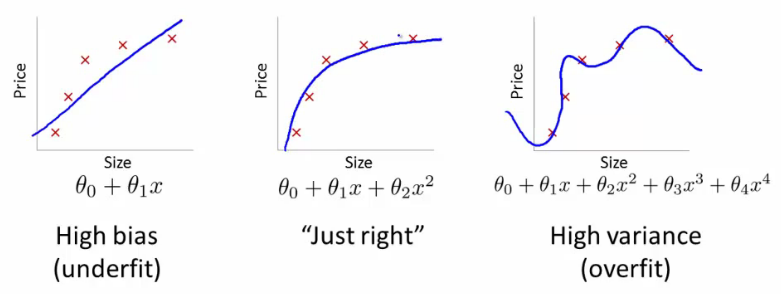

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice. Why is that? If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to overfitting. A validation set helps diagnose this problem.

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2)

In [ ]:
trainIds = train['Id']
testIds = test['Id']

In [ ]:
#??train.drop

In [ ]:
x_train = train.drop(['Id', 'groupId', 'matchId', target_col], axis=1)
x_train.head(1)

In [ ]:
y_train = train[target_col]
y_train.head()

In [ ]:
x_val = val.drop(['Id', 'groupId', 'matchId', target_col], axis=1)
x_val.head(1)

In [ ]:
y_val = val[target_col]
y_val.head()

In [ ]:
x_test = test.drop(['Id', 'groupId', 'matchId'], axis=1)
x_test.head(1)

In [ ]:
x_train.shape, x_test.shape

# Decision tree model
we have training data, validation data and test data now. So let try our first model. 

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
#%timeit 
dtree=DecisionTreeRegressor(max_depth=3)
dtree.fit(x_train, y_train)

In [ ]:
dtree.score(x_train, y_train)

In [ ]:
dtree.score(x_val, y_val)

In [ ]:
from IPython.display import SVG
from graphviz import Source
from sklearn import tree
graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=x_train.columns))
SVG(graph.pipe(format='svg'))

So let's explore this...

**How do you find a single best split?**
- So the  idea is to try out every variable and split on every posible value of that variable.

**Okay, this sounds simple but how do you measure the quality of the split?**

- You could take a weighted average of sample and mse to get the total mse and then just pick the best split.
Now you just have to recurse it for every posbile split till you hit max_depth and thats it. You have your decision tree.

In [ ]:
p_val = dtree.predict(x_val)

In [ ]:
def mae(p, t):
    return np.sum(np.abs(p - t)) / len(p)

In [ ]:
mae(p_val, y_val)

Let's now increase the depth to get our base score.

In [ ]:
dtree=DecisionTreeRegressor(max_depth=15)
dtree.fit(x_train, y_train)

In [ ]:
def print_score(mm):
    print("train r^2 " + str(mm.score(x_train, y_train)))
    print("validation r^2 " + str(mm.score(x_val, y_val)))
    p_val = mm.predict(x_val)
    p_train = mm.predict(x_train)
    print("mean absolute error(Train): " + str(mae(p_train, y_train)))
    print("mean absolute error(Validation): " + str(mae(p_val, y_val)))
print_score(dtree)

In [ ]:
p_test = dtree.predict(x_test)

In [ ]:
p_test

In [ ]:
submission = pd.DataFrame()
submission['Id'] = testIds
submission[target_col] = p_test

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission.csv", index=False)

Lets see how change depth of the tree changes training and validation score

In [ ]:
def train_and_get_score(max_depth):
    dtree=DecisionTreeRegressor(max_depth=max_depth)
    dtree.fit(x_train[:10000], y_train[:10000])
    p_val = dtree.predict(x_val[:1000])
    p_train = dtree.predict(x_train[:10000])
    return mae(p_train, y_train[:10000]), mae(p_val, y_val[:1000])

In [ ]:
train_and_get_score(5)

In [ ]:
train_score = []
valid_score = []
x_axis = []
for max_depth in range(1, 40, 5):
    ts, vs = train_and_get_score(max_depth)
    train_score.append(ts)
    valid_score.append(vs)
    x_axis.append(max_depth)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x_axis, train_score,)
plt.plot(x_axis, valid_score)
plt.ylabel('Score')
plt.xlabel('max_depth')
plt.show()

As you can see training error is going down as we increase max_depth in a decision tree. This is called overfitting. Which means model is specifically learning based on training data but not generalizing well. This is huge problem in decision tree.  
**How do we solve this?**

# Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1, max_depth=15, max_features='sqrt', n_estimators=100)
%time model.fit(x_train, y_train)

In [ ]:
print_score(model)

In [ ]:
model.estimators_[0]

In [ ]:
print_score(model.estimators_[0])

In [ ]:
#for dtree_model in model.estimators_:
#    print_score(dtree_model)
#    print("------------------------------------")

In [ ]:
p_test = model.predict(x_test)
submission = pd.DataFrame()
submission['Id'] = testIds
submission[target_col] = p_test
submission.to_csv("submission_random_forest_30.csv", index=False)

In [ ]:
feature_imp = pd.DataFrame(model.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
feature_imp

In [ ]:
feature_imp['importance'].nlargest(10).plot(kind='barh')

* walkDistance - Total distance traveled on foot measured in meters.
* killPlace - Ranking in match of number of enemy players killed.

In [ ]:
#import xgboost

In [ ]:
# xgb = xgboost.XGBRegressor(n_jobs=-1, n_estimators=100, learning_rate=0.2, gamma=0, subsample=0.75,
                           #colsample_bytree=1, max_depth=3)
# %time xgb.fit(x_train, y_train)

In [ ]:
#print_score(xgb)

In [ ]:
from lightgbm import LGBMRegressor
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 30,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}

model = LGBMRegressor(**params)
model.fit(
   x_train, y_train,
    eval_metric='mae',
    verbose=20,
)

In [ ]:
print_score(model)

In [ ]:
p_test = model.predict(x_test)
submission = pd.DataFrame()
submission['Id'] = testIds
submission[target_col] = p_test
submission.to_csv("submission_lightgdm.csv", index=False)

In [ ]:
feature_imp = pd.DataFrame(model.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
feature_imp['importance'].nlargest(10).plot(kind='barh')